# In this work, only LoF mutations are used: calculate how many risk genes we can obtain with Nsample = 550

## Some ways have been used:

### Don't know any count information $=>$ use Poisson distribution

### Know counts from published data (Removed)

### Use TADA method (Removed)

### Use the trio package (Removed)

I randomly chose 1000 genes, but it's probably better if choosing top 1000 genes from TADA results.

# Simulate counts from the Poisson distribution

## Some main steps:

nGene = Number of genes ( ~ 18500 genes)

. Randomly choose risk genes with prob = 1000/nGene

. Add relative risk into mutation rates of risk genes 

. Use Poisson distribution to sample all genes with new mutation rates

. Use Poisson test to obtain p values:

    At the $i^{th}$ gene, $p_value = P(X >= x_i| lambda = 2*Nsample*mu_i)$
 
 . Count genes with pvalues < 0.05
 
 Didn't adjust for all tests, with Nsample = 550: it's difficult to obtain significant values after adjustment


# Real counts from published data

## Use the data of AUT + EPI

Take a quick look at all information

#### DISEASE	NUM_INDIV

AUT	3985

CHD	362

EPI	356

ID	192

SCZ	1024

SIB_CONTROL	2049

### wc -l AUT+EPI.LoF.mut 

  637

(3985 AUT + 356 EPI) samples have 637 LoF mutations



### We will use the Autism data from the TADA paper to have obtain some neccessary information

In [23]:
data <- read.csv("TADA/data/TADA_results.csv", header = TRUE, as.is = TRUE)
mu <- data$mut.rate
mu.frac <- c(0.074, 0.32)

Nsample_old <- 2231 ##There are 308 de novo mutations in this sample set
Nsample <- 550
Ncount_old <- sum(data$dn.LoF)
nDenovo <- ceiling(Nsample*Ncount_old/Nsample_old )
nDenovo

mutLoF0 <- data$mut.rate*mu.frac[1] #(mu.frac[1]) # + mu.frac[2]) ##Mutation rates
nGene <- length(mutLoF0)

##Choose nRiskGene = 1000 genes, using index
indexRiskGene <- sample(1:nGene, 1000)

Ntimes <- 500 ##Do this work Ntimes
geneCountforPower2 <- NULL
geneCountforPowerList2 <- list()
geneCountList <- list()

poissonTestAll_data_allSimu <- NULL
poissonTestAll_data <- NULL

message("Number of genes: ", nGene)

[1] 76

Number of genes: 18735


In [24]:
for (kk in 1:Ntimes) {

#rrList <- seq(1, 30, by = 1)
rrList <- c(1, 2, 5, 10, 20, 25, 50)
finalResult <- matrix(0, ncol = length(rrList), nrow = nGene)
geneCountTable <- matrix(0, ncol = length(rrList), nrow = nGene)

##Add relative risks to risk genes
piRG <- 1000/nGene ##Proportion of risk genes
z <- rbinom(nGene, 1, piRG)
table(z)
for (ii in 1:length(rrList)){
  RR <- rrList[ii]

  mutLoF <- mutLoF0
  
#  mutLoF[z==1] <- mutLoF[z==1]*RR ##*rgamma(mutLoF[z==1], RR, rate = 1)
  mutLoF[1:1000] <- mutLoF[1:1000]*RR #rgamma(1000, RR, rate = 1)
  
  geneCount <- rpois(nGene, 2*mutLoF*Nsample)

    
    
  poissonTest <- ppois(geneCount - 1, lambda = 2*Nsample*mutLoF0, lower.tail = FALSE)
  
    mutLoFallDenovo <- mutLoF0[geneCount > 0]
    poissonTestAll <- ppois(sum(geneCount) - 1, sum(mutLoFallDenovo)*2*Nsample, lower.tail = FALSE)
    
    poissonTestAll_data[ii] <- poissonTestAll
    
  finalResult[, ii] <- poissonTest
  geneCountTable[, ii] <- geneCount
}

#apply(finalResult, 2, range)
t1 <- apply(finalResult, 2, function(x) length(x[x < 0.05]))
geneCountList[[kk]] <- geneCountTable

geneCountforPower2 <- rbind(geneCountforPower2, t1)
geneCountforPowerList2[[kk]] <- finalResult

    poissonTestAll_data_allSimu <- rbind(poissonTestAll_data_allSimu, poissonTestAll_data)
}


In [25]:
sum(geneCount)
sum(mutLoFallDenovo)
ppois(sum(geneCount) - 1, sum(mutLoFallDenovo)*2*Nsample, lower.tail = FALSE)


[1] 168

[1] 0.0005799999

[1] 0

In [26]:
allOut2 <- do.call(rbind, geneCountforPowerList2)


In [27]:
t2 <- t(apply(allOut2, 2, range)) ##Take a look at the smallest p of RR = 1
t2


9.055241e-07,1.000000e+00
1.209885e-06,1.000000e+00
1.081852e-07,1.000000e+00
3.910638e-10,1.000000e+00
1.111867e-09,1.000000e+00
1.590655e-14,1.000000e+00
1.099114e-14,1.000000e+00


In [42]:
gCountAll <- NULL
alpha0 <- c(2.5e-6, 2e-5, 2e-4, 1e-3, 2e-3, 0.05)
alpha0 <- c(2e-5, 0.05)
for (alphaThreshold in alpha0){
  
outData <- do.call(rbind, lapply(geneCountforPowerList2, function(x)
  apply(x, 2, function(y)
    length(y[y < alphaThreshold]))))
gCount <- apply(outData, 2, function(x) ceiling(median(x))) ###How many genes with this threshold?
gCount
gCountAll <- rbind(gCountAll, gCount)
}
gCountAll



gCount,0,0,0,0,1,2,7
gCount,37,39,46,58,81,93,144


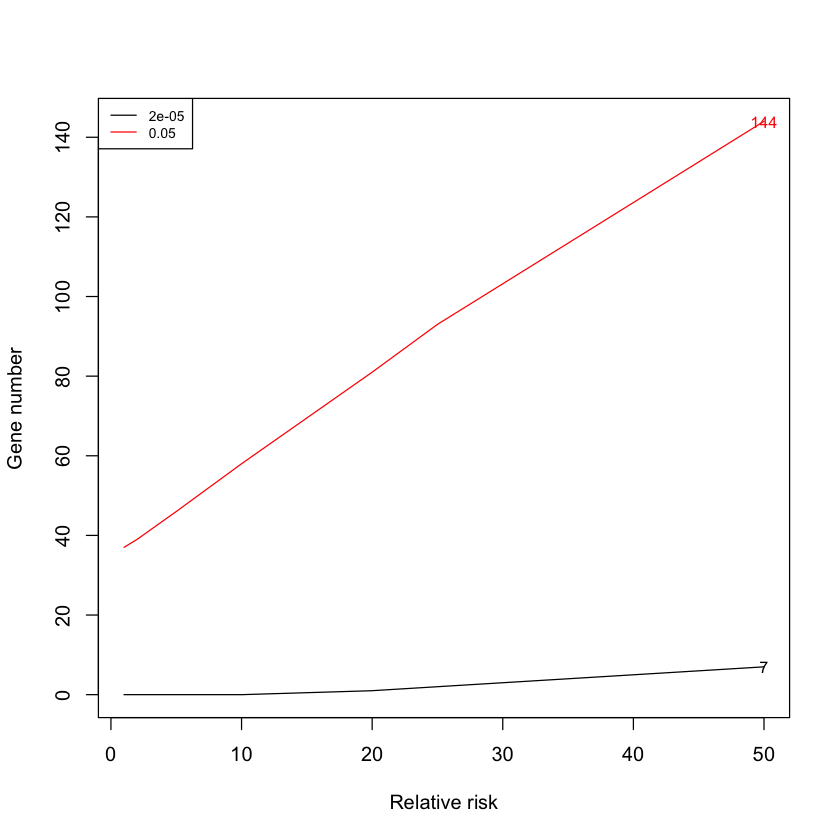

In [43]:
plot(rrList, gCountAll[dim(gCountAll)[1], ], col = 'white', xlab = 'Relative risk', ylab = 'Gene number',
     ylim = range(as.numeric(gCountAll)))
for (ii in 1:dim(gCountAll)[1]){
  lines(rrList, gCountAll[ii, ], col = ii)
    text(rrList[length(rrList)], 
         gCountAll[ii, dim(gCountAll)[2]], 
         gCountAll[ii, dim(gCountAll)[2]], col = ii, cex = 0.8)
}

legend("topleft", legend = alpha0, col = 1:length(alpha0), cex = 0.7, lty = 1)
#abline(h = 20)


gCount,0,0,0,0,0,0,2
gCount,0,0,0,0,1,2,7
gCount,0,0,0,0,2,3,10
gCount,4,4,4,6,8,10,21
gCount,14,14,16,20,27,31,53
gCount,37,39,46,58,81,93,144


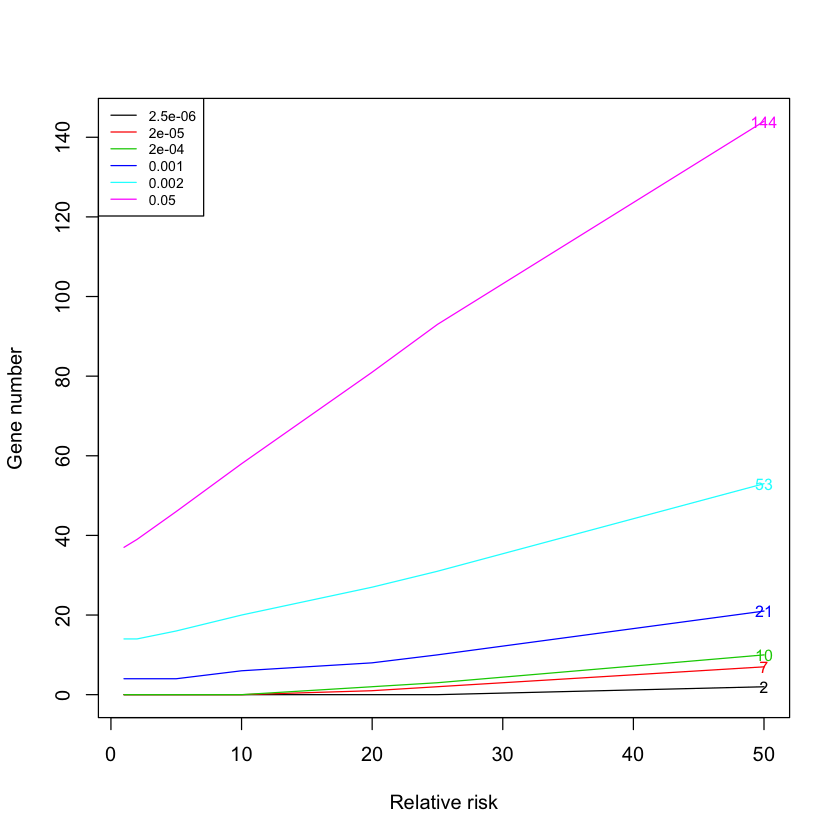

In [44]:
gCountAll <- NULL
alpha0 <- c(2.5e-6, 2e-5, 2e-4, 1e-3, 2e-3, 0.05)
#alpha0 <- c(2e-5, 0.05)
for (alphaThreshold in alpha0){
  
outData <- do.call(rbind, lapply(geneCountforPowerList2, function(x)
  apply(x, 2, function(y)
    length(y[y < alphaThreshold]))))
gCount <- apply(outData, 2, function(x) ceiling(median(x))) ###How many genes with this threshold?
gCount
gCountAll <- rbind(gCountAll, gCount)
}
gCountAll
                
                plot(rrList, gCountAll[dim(gCountAll)[1], ], col = 'white', xlab = 'Relative risk', ylab = 'Gene number',
     ylim = range(as.numeric(gCountAll)))
for (ii in 1:dim(gCountAll)[1]){
  lines(rrList, gCountAll[ii, ], col = ii)
    text(rrList[length(rrList)], 
         gCountAll[ii, dim(gCountAll)[2]], 
         gCountAll[ii, dim(gCountAll)[2]], col = ii, cex = 0.8)
}

legend("topleft", legend = alpha0, col = 1:length(alpha0), cex = 0.7, lty = 1)
#abline(h = 20)


### We will summarize how many counts for each RR below.
 

In [31]:
countSum <- lapply(geneCountList, function(x) apply(x, 2, sum))
countSum[[1]]
rrList

[1]  52  38  64  58  60 110 165

[1]  1  2  5 10 20 25 50

In [32]:
t.countSum <- do.call(rbind, countSum) ##See all simulated counts
apply(t.countSum, 2, range) ##See a range of all these values

head(t.countSum)

24,23,31,36,59,68,123
54,59,69,92,107,120,199


52,38,64,58,60,110,165
40,32,40,71,87,107,149
43,34,38,59,81,93,159
49,34,46,57,86,112,156
36,29,37,56,103,108,149
34,39,44,77,89,97,168


### Take a look at the predicted counts of de novos

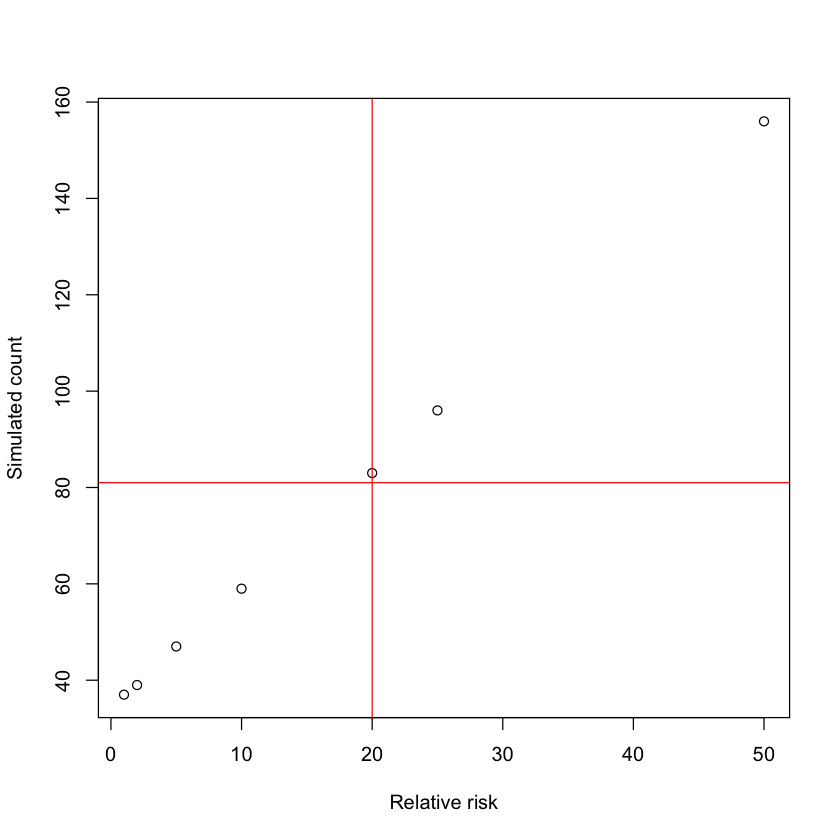

In [33]:
    Nsample_old <- 3985 + 356 ##There are 637 de novo mutations in this sample set
Nsample <- 550
Ncount_old <- 637
nPredictedDenovo <- ceiling(Nsample*Ncount_old/Nsample_old )
    
countSumAverage <- apply(do.call(rbind, countSum), 2, median)

    
    
    plot(rrList, countSumAverage, xlab = 'Relative risk', ylab = 'Simulated count')
    
    abline(v = 20, col = 'red')
    abline(h = nPredictedDenovo, col = 'red') ## Draw a line for predicted counts



### Now, will check how many recurrent genes are from simulated data?

In [34]:
recurrentCount <- lapply(geneCountList, function(x) apply(x, 2, function(y) length(y[y>1])))
recurrentCount[[1]]

recurrentCountAll <- do.call(rbind, recurrentCount)

apply(recurrentCountAll, 2, median) ##Not strong, why is it? So, the way we let equal RRs for all risk genes is not suitable


[1]  0  0  0  0  1  3 14

[1]  0  0  0  0  2  3 10

### Take a look at the Poisson test result for all counts

In [35]:
poissonTestAll_data_allSimu[1:3, 1:3] ##Small

poissonTestAll_data,2.023023e-105,3.452805e-75,2.695909e-133
poissonTestAll_data,5.547686e-82,7.841861e-69,1.711159e-84
poissonTestAll_data,8.381351e-86,1.095677e-71,5.536974e-77


# Use real counts from published data

## A little bit messy below, and not the results we want

## Use the data of AUT + EPI

Take a quick look at all information

#### DISEASE	NUM_INDIV

AUT	3985

CHD	362

EPI	356

ID	192

SCZ	1024

SIB_CONTROL	2049

### wc -l AUT+EPI.LoF.mut 

  637

(3985 AUT + 356 EPI) samples have 637 LoF mutations

#### Here, I randomly allocate counts to nGene, but counts should be allocated to the top 1000 genes


In [36]:
sum(data$dn.LoF)

[1] 308